In [3]:
import mplsoccer as mpl
import matplotlib as matplotlib
import numpy as np 
import pandas as pd
import json
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.lines as lines
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch ,Pitch
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import urllib
from highlight_text import HighlightText, ax_text, fig_text
import matplotlib.gridspec as gridspec
from sklearn.cluster import KMeans
import unidecode
import matplotlib.patches as patches
from skimage import io
import math

In [4]:
team = 'France'
imageurl = r''

In [5]:
query = f'''
SELECT
  Minute,
  Second,
  Period,
  TeamId,
  teams.team as team,
  PlayerId,
  players.player as Player,
  X,
  Y,
  Type,
  OutcomeType,
  events,
  PassEndX,
  PassEndY,
  Zone,
  Length,
  Angle,
  MatchId,
FROM
  `DATASET.Event_Data.World_Cup_2022` as wc,
UNNEST (SatisfiedEventsTypes) as events
LEFT JOIN 
  `DATASET.Lookup_Tables.Players` as players ON wc.PlayerId = players.id
LEFT JOIN 
  `DATASET.Lookup_Tables.Teams` as teams ON wc.TeamId = teams.id
WHERE
  isTouch = True
  AND team = '{team}'

'''

df = pd.read_gbq(query, project_id='DATASET').drop_duplicates()
df['Player'] = df['Player'].apply(lambda x: unidecode.unidecode(x) if x is not None else x)

In [6]:
fbref_link = 'https://fbref.com/en/squads/b1b36dcd/2022/matchlogs/schedule/France-Men-Scores-and-Fixtures'
from bs4 import BeautifulSoup
import ScraperFC as sfc
soup = BeautifulSoup(urllib.request.urlopen(fbref_link).read(), 'html.parser')
tags = soup.find_all('a', href=True)
links = ['https://www.fbref.com' + x['href'] for x in tags if ('Match Report' in x.text) and ('World-Cup' in x['href'])]
shots_df = pd.DataFrame()
scraper = sfc.FBRef()
for link in links:
    match = scraper.scrape_match(link=link)
    match = match['Shots'].values[0].loc["Both"]
    match.columns = match.columns.droplevel()
    match = match[['Minute','Player','Squad','xG','Outcome']]
    shots_df = shots_df.append(match)
shots_df = shots_df[shots_df['Squad'].str.contains(team)].dropna(axis=1)
shots_df['Adjusted Time'] = shots_df['Minute'].apply(lambda x:sum([int(float(n)) for n in str(x).split('+')])) - 1
shots_df['Player'] = shots_df['Player'].apply(lambda x: unidecode.unidecode(x))
scraper.close()

In [8]:
player_lst = ['Jules Kounde','Raphael Varane','Dayot Upamecano','Theo Hernandez','Aurelien Tchouameni','Adrien Rabiot','Ousmane Dembele','Antoine Griezmann','Kylian Mbappe','Olivier Giroud']
#check if empty
[x for x in shots_df['Player'].unique().tolist() if x not in df[(df['Type'].isin(['MissedShots','ShotOnPost','SavedShot', 'Goal'])) & (df['Period'] != 6)].drop('events',axis=1).drop_duplicates()['Player'].unique().tolist()]

[]

In [9]:
df[(df['Type'].isin(['MissedShots','ShotOnPost','SavedShot', 'Goal'])) & (df['Period'] != 6)].drop('events',axis=1).drop_duplicates().shape[0]

78

In [18]:
def draw_network(df, ax,player_lst):
    def create_combos(df):
        passes = df[df['Type'] == 'Pass']
        player = []
        from_player = []
        counts = []
        for i in range(0, len(player_lst)):
            curr = player_lst[i]
            for j in range(i + 1, len(player_lst)):
                count = 0
                player.append(curr)
                from_player.append(player_lst[j])
                for k in range(0, len(passes)):
                    if passes.iloc[k]['Player'] == curr and passes.iloc[k]['PassedTo'] == player_lst[j]:
                        count += 1
                counts.append(count)
        combos = pd.DataFrame({
            'Player': player,
            'FromPlayer': from_player,
            'Count': counts
        }).sort_values('Count',ascending=False)
        combos['width'] = combos['Count']/combos['Count'].max() * MAX_LINE_WIDTH
        combos['alpha'] = combos['Count']/combos['Count'].max() * MAX_ALPHA + MIN_ALPHA
        return combos
    def heatmap_plot(ax, player,df):
        player_df = df[df['PassedTo'] == player]
        kde = smallPitch.kdeplot(player_df['PassEndX'],player_df['PassEndY'], ax=ax, shade=True, levels=200,cmap=cmap)
    def network(ax,combos, player,x,y):
        player_df = combos[(combos['Player'] == player) & (combos['Count'] > 2)]
        for i,row in player_df.iterrows():
            target = player_lst.index(row['FromPlayer'])
            x_target = x_coords[target]
            y_target = y_coords[target]
            ax.plot([x * 100 + x_adjust,x_target * 100+x_adjust],[y * 100+y_adjust,y_target * 100 + y_adjust],color=NETWORK_COLOR,linewidth=row['width'],alpha=row['alpha'],zorder=1)
    
    x_coords = [0.04,0.27,0.53,0.76, 0.25,0.55,0.4,0.1,0.4,0.7]
    y_coords = [0.15,0.1,0.1,0.15,0.34,0.34,0.55,0.55,0.55,0.7]
    x_text = [10,36,64,89,22.5,50,76.5,22.5,50,76.5]
    y_text = [11,6,6,11,39.5,31.5,39.5,69,74,69]
    pitch = VerticalPitch(pitch_type='opta',pitch_color = BG_COLOR,line_color='white',linewidth = 0.6, line_alpha=0.4)
    smallPitch = VerticalPitch(pitch_type='opta',pitch_color=BG_COLOR, line_color='white',line_zorder=3,linewidth = 0.6, line_alpha=0.4)
    pitch.draw(ax= ax)
    combos = create_combos(df)
    cmap=LinearSegmentedColormap.from_list('test',cmap_lst, N=256) 
    for x,y,player in zip(x_coords,y_coords,player_lst):
        new = ax.inset_axes([0.8-x,y,0.2,0.2])
        smallPitch.draw(ax=new)
        heatmap_plot(new,player,df)
        network(ax, combos, player,x,y)
    for x,y,player in zip(x_text,y_text,player_lst):
        ax.text(x,y,player,fontsize=9,ha='center',color = NOTES_COLOR,font=FONT,bbox=dict(facecolor=TEXTBOX, edgecolor=TEXTBOX, boxstyle='round,pad=0.2',alpha=0.1),fontweight='demi')

    ax.text(0,100.5,'Passing Network and Pass Received Heatmaps',ha='right',font=FONT,fontsize=6.5,color=NOTES_COLOR,alpha=0.7,va='bottom')

    return ax

In [11]:
def cluster_passes(df,ax,cmap_lst):
    def plot_arrows(X,ax,cmap_lst):
        kmeans = KMeans(n_clusters=3)
        kmeans.fit(X)
        X['cluster'] = kmeans.labels_
        clusters = X.groupby(X['cluster']).mean().reset_index(names ='cluster')
        pitch.lines(X['X'],X['Y'],X['PassEndX'],X['PassEndY'],ax=ax,lw=1.2,color='grey',alpha =0.1)
        pitch.scatter(X['PassEndX'],X['PassEndY'],ax=ax,color='grey',alpha =0.1,s=20,linewidths=0)
        for i,cluster in enumerate(X['cluster'].unique()):
            tmp = clusters[clusters['cluster']==cluster]
            pct = len(X[X['cluster']==cluster])/len(X)
            alpha = pct + 0.5
            pitch.lines(tmp['X'],tmp['Y'],tmp['PassEndX'],tmp['PassEndY'],ax=ax,lw=1.2,color=cmap_lst[i+1],alpha=alpha)
            pitch.scatter(tmp['PassEndX'],tmp['PassEndY'],ax=ax,color=cmap_lst[i+1],s=20,linewidths=0,alpha = alpha)
            end_x = tmp['PassEndY'].values[0]
            end_y = tmp['PassEndX'].values[0]
            start_x = tmp['Y'].values[0]
            start_y = tmp['X'].values[0]
            ax.text((start_x + end_x)/2 + 8,(start_y + end_y)/2 + 2,f'{pct:.0%}',ha='center',va='center',color=NOTES_COLOR,fontweight='bold',fontsize = 10,font = FONT,
                        bbox = dict(facecolor=cmap_lst[i+1],alpha = 0.5,boxstyle = 'round, rounding_size = 0.2',edgecolor = cmap_lst[i+1],pad = 0.2))

        return ax 
    #attacking third
    df = df[(df['Type'] == 'Pass') & (df['OutcomeType'] == True) & (df['PassEndX'] > 66) & (df['X'] < 66)][['X','Y','PassEndX','PassEndY']].drop_duplicates()
    pitch = VerticalPitch(half=True,pitch_type='opta',pitch_color = BG_COLOR,line_color='white',linewidth = 0.6, line_alpha=0.4,pad_bottom=0.5)
    pitch.draw(ax=ax)
    ax = plot_arrows(df,ax,cmap_lst)
    ax.text(2,51,"Types of passes into the final 1/3", ha='right',color = NOTES_COLOR,fontsize = 5.6,alpha =0.6)
    return ax


In [12]:
def process_df(df):
        df = df.sort_values(['MatchId', 'Period','Minute','Second']).drop('events',axis=1).drop_duplicates().reset_index(drop=True)
        df['TotalTime'] = df['Minute']*60 + df['Second']
        passed_from = [None]
        for i,row in df.iloc[1:].iterrows():
            prev = df.loc[i - 1]
            if (prev['Type'] == 'Pass') & (prev['OutcomeType'] == True) & (prev['MatchId'] == row['MatchId']) & (abs(prev['TotalTime'] - row['TotalTime']) < 10):
                passed_from.append(prev['Player'])
            else:
                passed_from.append(None)

        passed_to  = []
        for i,row in df.iterrows():
            if (row['Type'] == 'Pass') & (row['OutcomeType'] == True) & (row['MatchId'] == row['MatchId']) & (abs(row['TotalTime'] - row['TotalTime']) < 10):
                passed_to.append(df.loc[i+1]['Player'])
            else: 
                passed_to.append(None)
        df['PassedFrom'] = passed_from
        df['PassedTo'] = passed_to
        return df
processed = process_df(df)

In [13]:
def shotmap(df,ax,cmap_lst):
    df = df[(df['Type'].isin(['MissedShots','ShotOnPost','SavedShot', 'Goal'])) & (df['Period'] != 6)].drop('events',axis=1).drop_duplicates().merge(shots_df,left_on=['Minute','Player'],right_on =['Adjusted Time','Player'],how='left').dropna(subset=['xG'])
    pitch = VerticalPitch(half=True,pitch_type='opta',pitch_color = BG_COLOR,line_color='white',linewidth = 0.6, line_alpha=0.4,pad_bottom=0.5)
    pitch.draw(ax=ax)
    pitch.scatter(df['X'],df['Y'],ax=ax,color=df['Type'].apply(lambda x: cmap_lst[2] if x =='Goal' else 'gray'),s= df['xG'] * 15 ** 2 ,alpha = df['Type'].apply(lambda x: 1 if x =='Goal' else 0.4 ),linewidths=0,zorder =3)

    fontsize = 6.5
    fontweight = 'heavy'
    alpha = 0.75
    ax.text(2,51,'Larger circles indicate shots with higher xG',fontsize=fontsize,ha='right',color = NOTES_COLOR,font=FONT,alpha = 0.65)
    ax.text(90,70,'Goals:',bbox = dict(facecolor=cmap_lst[2],alpha=0.8,boxstyle = 'round'), fontsize=fontsize,ha='left',color = 'white',font=FONT,fontweight=fontweight,alpha = alpha )
    ax.text(78,70,len(df[df['Type'] =='Goal']),fontsize=fontsize,ha='left',color = 'white',font=FONT,fontweight=fontweight,alpha = alpha+0.25)
    ax.text(90,66,'Shots:',bbox = dict(facecolor='grey',alpha=alpha-0.2,boxstyle = 'round'), fontsize=fontsize,ha='left',color = 'white',font=FONT,fontweight=fontweight,alpha = alpha)
    ax.text(78,66,len(df),fontsize=fontsize,ha='left',color = 'white',font=FONT,fontweight=fontweight,alpha = alpha)
    ax.text(90,62,'xG/Shot:',bbox = dict(facecolor='grey',alpha=alpha-0.2,boxstyle = 'round'), fontsize=fontsize,ha='left',color = 'white',font=FONT,fontweight=fontweight,alpha = alpha)
    ax.text(77,62,round(df['xG'].mean(),2),fontsize=fontsize,ha='left',color = 'white',font=FONT,fontweight=fontweight,alpha = alpha)
    return ax

In [14]:
def xt_chart(df,ax):
    xt_grid = np.array(pd.read_json('https://karun.in/blog/data/open_xt_12x8_v1.json'))
    xT_rows, xT_cols = xt_grid.shape
    df = df[(df['Type'] == 'Pass') & (df['OutcomeType'] == True)]
    df['x1_bin'] = pd.cut(df['X'], bins=xT_cols, labels=False)
    df['y1_bin'] = pd.cut(df['Y'], bins=xT_rows, labels=False)
    df['x2_bin'] = pd.cut(df['PassEndX'], bins=xT_cols, labels=False)
    df['y2_bin'] = pd.cut(df['PassEndY'], bins=xT_rows, labels=False)
    df['start_zone_value'] = df[['x1_bin', 'y1_bin']].apply(lambda x: xt_grid[x[1]][x[0]], axis=1)
    df['end_zone_value'] = df[['x2_bin', 'y2_bin']].apply(lambda x: xt_grid[x[1]][x[0]], axis=1)
    df['xT'] = df['end_zone_value'] - df['start_zone_value']
    df = df.drop(['x1_bin', 'y1_bin','x2_bin', 'y2_bin','start_zone_value','end_zone_value'],axis=1)
    xt = df[['Player','xT']].groupby('Player').sum().sort_values('xT')
    xt = xt[xt['xT'] > 0].reset_index(drop=False)
    # ax.barh(xt['Player'],xt['xT'],color=cmap_lst[2])
    # ax.axis('off')
    # i = 0
    # for i,row in xt.iterrows():
    #     if (row['xT'] < 0):
    #         adjust = 0.7 #change this as fit
    #     else:
    #         adjust = 0.2
    #     ax.text(-1,i,row['Player'],ha='right',va='center',color=NOTES_COLOR,fontweight='demibold',fontsize = 10,font = FONT)
    #     ax.text(row['xT']+ adjust,i,f'{row["xT"]:.2f}',ha='left',va='center',color=NOTES_COLOR,fontweight='demibold',fontsize = 10,font = FONT)
    #     i +=1
    # ax.plot([0,0],[-0.7,i - 0.3],NOTES_COLOR,linewidth=2) #change this
    cmap=LinearSegmentedColormap.from_list('test',cmap_lst, N=256)
    colors = plt.cm.ScalarMappable(cmap=cmap).to_rgba(xt['xT']/xt['xT'].mean())
    xt['Pct'] = xt['xT']/xt['xT'].sum() * 100
    xt_label = xt.apply(lambda x: x['Player'] + '\n(' + str(round(x['xT'],2))  + ')' if x['Pct'] > XT_THRESHOLD else '',axis=1)
    #     wedges,texts, labels = ax.pie(xt['xT'],labels=xt_label,colors=colors,autopct=lambda pct: '{:1.1f}%'.format(pct)  if pct > XT_THRESHOLD   else '' ,startangle=90,pctdistance =0.75,explode = [0.1]*len(xt)
    #                                                                                     ,textprops={'color':NOTES_COLOR,'fontweight':'demibold','font':FONT})
    wedges,texts, labels = ax.pie(xt['xT'],colors=colors,autopct=lambda pct: '{:1.1f}%'.format(pct)  if pct > XT_THRESHOLD   else '' ,startangle=90,pctdistance =0.75,explode = [0.1]*len(xt)
                                                                                        ,textprops={'color':NOTES_COLOR,'fontweight':'demibold','font':FONT})
    for text,label in zip(texts,labels):
        text.set_fontsize(6.5)
        label.set_fontsize(7)
        text.set_fontweight('demi')
        label.set_fontweight('demi')
    kw = dict(arrowprops=dict(arrowstyle="-",color=NOTES_COLOR,lw=0.4), zorder=0, va="center")
    for i, p in enumerate(wedges):
        if labels[i].get_text() != '':
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            t = ax.annotate(xt_label[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y), wrap = True,
                        horizontalalignment=horizontalalignment,color = NOTES_COLOR, fontsize = 6.5,**kw)
            if horizontalalignment =='left':
                t._get_wrap_line_width = lambda : 5
    centre_circle = patches.Circle((0,0),radius =0.6,facecolor=BG_COLOR,edgecolor=BG_COLOR)
    ax.add_patch(centre_circle)
    ax.text(1.854,-1.7,'Team Pass xT accumulated',ha='right',va='center',color=NOTES_COLOR,alpha=0.7,fontsize = 6.5,font = FONT)
    return texts


In [15]:
plt.rcParams['figure.figsize'] = [20, 12]
x_adjust = 10
y_adjust = 5
MAX_LINE_WIDTH = 10
MAX_ALPHA = 0.7
MIN_ALPHA = 0.07
XT_THRESHOLD = 5


BG_COLOR = '#101419'
cmap_lst = [BG_COLOR,'#136F63','#22AAA1','#4CE0D2']
NOTES_COLOR = '#E0E1DD'
NETWORK_COLOR ='#DCC48E'
TEXTBOX = 'grey' 
CREDIT_SIZE =6
TITLE_COLOR = '#E0E1DD'
TITLE_SIZE = 28
TITLEFONT ='Georgia'
FONT = 'Roboto'
SUBTITLE_SIZE = 10



In [16]:
def plot_defence(df,ax,cmap_lst,sonar_cmap):
    def cluster_plot(X,ax,color):
        cols = X.columns.tolist()
        pitch = Pitch(pitch_type='opta',pitch_color = BG_COLOR,line_color='white')
        kmeans = KMeans(n_clusters=4)
        kmeans.fit(X)
        X['cluster'] = kmeans.labels_
        clusters = X.groupby(X['cluster']).mean().reset_index(names ='cluster')
        pitch.lines(X[cols[0]],X[cols[1]],X[cols[2]],X[cols[3]],ax=ax,lw=1.2,color='grey',alpha =1)
        pitch.scatter(X[cols[2]],X[cols[3]],ax=ax,color='grey',alpha =1,s=20,linewidths=0)
        # for i,cluster in enumerate(X['cluster'].unique()):
        #     tmp = clusters[clusters['cluster']==cluster]
        #     pct = len(X[X['cluster']==cluster])/len(X)
        #     alpha = 1
        #     pitch.lines(tmp[cols[0]],tmp[cols[1]],tmp[cols[2]],tmp[cols[3]],ax=ax,lw=1.2,color=color,alpha=alpha)
        #     pitch.scatter(tmp[cols[2]],tmp[cols[3]],ax=ax,color=color,s=20,linewidths=0,alpha = alpha)
    def sonar_plot(newax,df,cmap_lst):
        def get_player_df(player_df,bins):
            angle = player_df['Angle']
            player_df['Bins'] = pd.DataFrame(pd.cut(angle,bins=bins,include_lowest=True))
            length = player_df.groupby('Bins').mean()['Length']
            counts = player_df['Bins'].value_counts()
            working_df = pd.concat([length,counts],axis=1).reset_index()
            working_df['Midpoint'] = working_df['index'].apply(lambda x:x.mid)
            working_df.drop('index',axis=1,inplace=True)
            working_df.columns = ['Mean','Count','Midpoint']
            working_df['Scaled Length'] = working_df['Mean']**2
            mean_x = player_df['X'].mean()
            mean_y = player_df['Y'].mean()
            return player_df, working_df.fillna(0), mean_x,mean_y
        player_df, working_df,x,y = get_player_df(df,10)
        cmap=LinearSegmentedColormap.from_list('test',cmap_lst, N=256) 
        colors = plt.cm.ScalarMappable(cmap=cmap).to_rgba(working_df['Count']/working_df['Count'].mean())
        newax = ax.inset_axes([0.35,0.33,0.3,0.3],projection='polar')
        newax.set_theta_zero_location("E")
        newax.bar(working_df['Midpoint'],working_df['Scaled Length'],color = colors)
        newax.axis('off')
        return

    defence = df[df['Type'].isin(['Interception','Clearance','BlockedPass','Disposessed','Tackle'])].drop('events',axis=1).drop_duplicates()
    pitch = Pitch(pitch_type='opta',line_zorder=2,pitch_color = BG_COLOR,line_color='white',linewidth = 0.6, line_alpha=0.4,pad_top=10)
    pitch.draw(ax=ax)
    cmap=LinearSegmentedColormap.from_list('test',cmap_lst, N=256) 
    kde = pitch.kdeplot(defence['X'],defence['Y'], ax=ax, shade=True, levels=200,cmap=cmap)
    mean_x = defence['X'].mean() * 1.25
    ax.text(100,-6,f'Average Height of Def. Actions: {mean_x:.2f}m',ha='right',va='center',color=NOTES_COLOR,alpha=0.75,fontsize = 6.75,font = FONT)
    ax.text(100,104,'Def. Actions Heatmap | Transition Pass Sonar',ha='right',va='center',color=NOTES_COLOR,alpha=0.75,fontsize = 6.75,font = FONT)
    ax.vlines(mean_x,-8,105,NOTES_COLOR,linewidth=1,linestyle='dotted')

    #change in possession
    raw = df.drop('events',axis=1).drop_duplicates().sort_values(['MatchId','Period','Minute','Second']).reset_index(drop=True)
    change = [False,False]
    for i,row in raw.iloc[2:].iterrows():
        prev = raw.loc[i-1]
        prev_s = raw.iloc[i-1]
        if ((prev['Type'] in['Tackle','Interception','BlockedPass']) and (prev['OutcomeType'] == True)  or ( (prev_s['Type'] in['Tackle','Interception','BlockedPass']) and (prev_s['OutcomeType'] == True))) and (row['Type']=='Pass'):
            change.append(True)
        else:
            change.append(False)
    raw['change'] = change
    changed = raw[raw['change'] == True]
    # cluster_plot(changed[['X','Y','PassEndX','PassEndY']],ax,'white')
    # pitch.scatter(changed['PassEndX'],changed['PassEndY'],ax=ax,color='white',s=6,linewidths=0,alpha = 0.1)
    # pitch.lines(changed['X'],changed['Y'],changed['PassEndX'],changed['PassEndY'],ax=ax,lw=0.8,color='white',alpha =0.1)
    sonar_plot(ax,changed,sonar_cmap)

    return ax

In [17]:
def draw_network(df, ax,player_lst):
    def create_combos(df):
        passes = df[df['Type'] == 'Pass']
        player = []
        from_player = []
        counts = []
        for i in range(0, len(player_lst)):
            curr = player_lst[i]
            for j in range(i + 1, len(player_lst)):
                count = 0
                player.append(curr)
                from_player.append(player_lst[j])
                for k in range(0, len(passes)):
                    if passes.iloc[k]['Player'] == curr and passes.iloc[k]['PassedTo'] == player_lst[j]:
                        count += 1
                counts.append(count)
        combos = pd.DataFrame({
            'Player': player,
            'FromPlayer': from_player,
            'Count': counts
        }).sort_values('Count',ascending=False)
        combos['width'] = combos['Count']/combos['Count'].max() * MAX_LINE_WIDTH
        combos['alpha'] = combos['Count']/combos['Count'].max() * MAX_ALPHA + MIN_ALPHA
        return combos
    def heatmap_plot(ax, player,processed):
        processed['Dist'] = (processed['X'] - processed['PassEndX'])**2 + (processed['Y'] - processed['PassEndY'])**2
        processed['Dist'] = processed['Dist'].apply(lambda x: np.sqrt(x))
        progressive = processed[processed['Dist'] > 6.25]
        X = progressive[progressive['PassedTo'] == player][['X','Y','PassEndX','PassEndY']].drop_duplicates()
        #kde = smallPitch.kdeplot(player_df['PassEndX'],player_df['PassEndY'], ax=ax, shade=True, levels=200,cmap=cmap)
        kmeans = KMeans(n_clusters=2)
        kmeans.fit(X)
        X['cluster'] = kmeans.labels_
        clusters = X.groupby(X['cluster']).mean().reset_index(names ='cluster')
        pitch.lines(X['X'],X['Y'],X['PassEndX'],X['PassEndY'],ax=ax,lw=1.2,color='grey',alpha =0.1)
        pitch.scatter(X['PassEndX'],X['PassEndY'],ax=ax,color='grey',alpha =0.1,s=20,linewidths=0)
        for i,cluster in enumerate(X['cluster'].unique()):
            tmp = clusters[clusters['cluster']==cluster]
            pct = len(X[X['cluster']==cluster])/len(X)
            alpha = 1
            pitch.lines(tmp['X'],tmp['Y'],tmp['PassEndX'],tmp['PassEndY'],ax=ax,lw=1.5,color=cmap_lst[i*2 + 1],alpha=alpha)
            pitch.scatter(tmp['PassEndX'],tmp['PassEndY'],ax=ax,color=cmap_lst[i*2 + 1],s=15,linewidths=0,alpha = alpha)
        pitch.kdeplot(X['PassEndX'],X['PassEndY'], ax=ax, shade=True, levels=200,cmap=cmap,alpha=0.6)
    def network(ax,combos, player,x,y):
        player_df = combos[(combos['Player'] == player) & (combos['Count'] > 2)]
        for i,row in player_df.iterrows():
            target = player_lst.index(row['FromPlayer'])
            x_target = x_coords[target]
            y_target = y_coords[target]
            ax.plot([x * 100 + x_adjust,x_target * 100+x_adjust],[y * 100+y_adjust,y_target * 100 + y_adjust],color=NETWORK_COLOR,linewidth=row['width'],alpha=row['alpha'],zorder=1)
    
    x_coords = [0.04,0.27,0.53,0.76,0.15,0.4,0.65,0.15,0.4,0.65]
    y_coords = [0.15,0.1,0.1,0.15,0.42,0.34,0.42,0.7,0.75,0.7]
    x_text = [10,36,64,89,22.5,50,76.5,22.5,50,76.5]
    y_text = [11,6,6,11,39.5,31.5,39.5,69,74,69]
    pitch = VerticalPitch(pitch_type='opta',pitch_color = BG_COLOR,line_color='white',linewidth = 0.6, line_alpha=0.4)
    smallPitch = VerticalPitch(pitch_type='opta',pitch_color=BG_COLOR, line_color='white',line_zorder=3,linewidth = 0.6, line_alpha=0.4)
    pitch.draw(ax= ax)
    combos = create_combos(df)
    cmap=LinearSegmentedColormap.from_list('test',cmap_lst, N=256) 
    for x,y,player in zip(x_coords,y_coords,player_lst):
        new = ax.inset_axes([0.8-x,y,0.2,0.2])
        smallPitch.draw(ax=new)
        heatmap_plot(new,player,df)
        network(ax, combos, player,x,y)
    for x,y,player in zip(x_text,y_text,player_lst):
        ax.text(x,y,player,fontsize=9,ha='center',color = NOTES_COLOR,font=FONT,bbox=dict(facecolor=TEXTBOX, edgecolor=TEXTBOX, boxstyle='round,pad=0.2',alpha=0.1),fontweight='demi')

    ax.text(1.2,100.5,'Passing Network and Pass Received Heatmaps',ha='right',font=FONT,fontsize=6.5,color=NOTES_COLOR,alpha=0.7,va='bottom')

    return ax

In [15]:
def plot_carries_passes(processed,ax):
    def cluster_plot(X,ax,color):
        cols = X.columns.tolist()
        pitch = VerticalPitch(pitch_type='opta',pitch_color = BG_COLOR,line_color='white')
        kmeans = KMeans(n_clusters=4)
        kmeans.fit(X)
        X['cluster'] = kmeans.labels_
        clusters = X.groupby(X['cluster']).mean().reset_index(names ='cluster')
        pitch.lines(X[cols[0]],X[cols[1]],X[cols[2]],X[cols[3]],ax=ax,lw=1.2,color='grey',alpha =0.05)
        pitch.scatter(X[cols[2]],X[cols[3]],ax=ax,color='grey',alpha =0.05,s=20,linewidths=0)
        for i,cluster in enumerate(X['cluster'].unique()[:3]):
            tmp = clusters[clusters['cluster']==cluster]
            pct = len(X[X['cluster']==cluster])/len(X)
            alpha = pct + 0.5
            pitch.lines(tmp[cols[0]],tmp[cols[1]],tmp[cols[2]],tmp[cols[3]],ax=ax,lw=1.2,color=color,alpha=alpha)
            pitch.scatter(tmp[cols[2]],tmp[cols[3]],ax=ax,color=color,s=20,linewidths=0,alpha = alpha)
            end_x = tmp[cols[3]].values[0]
            end_y = tmp[cols[2]].values[0]
            start_x = tmp[cols[1]].values[0]
            start_y = tmp[cols[0]].values[0]
            ax.text((start_x + end_x)/2 + 8,(start_y + end_y)/2 + 2,f'{pct:.0%}',ha='center',va='center',color=NOTES_COLOR,fontweight='bold',fontsize = 10,font = FONT,
                        bbox = dict(facecolor=cmap_lst[i+1],alpha = 0.5,boxstyle = 'round, rounding_size = 0.2',edgecolor = color,pad = 0.2))

    fromx = [None]
    fromy =[None]
    for i,row in processed.iloc[1:].iterrows():
        prev = processed.loc[i - 1]
        if (row['PassedFrom'] != None) & (prev['MatchId'] == row['MatchId']) & (prev['Period'] == row['Period']):
            fromx.append(prev['PassEndX'])
            fromy.append(prev['PassEndY'])
        else:
            fromx.append(None)
            fromy.append(None)
    processed['FromX'] = fromx
    processed['FromY'] = fromy
    processed['CarryDist'] = (processed['X'] - processed['FromX'])**2 + (processed['Y'] - processed['FromY'])**2
    processed['CarryDist'] = processed['CarryDist'].apply(lambda x: np.sqrt(x))
    processed['CarryDistToGoal'] = processed['X'] - processed['FromX']
    processed['DistToGoal'] = processed['PassEndX'] - processed['X']
    threshold = 10 * 1.35 #yards
    progressive_carry = processed[(processed['CarryDist'] > threshold) & (processed['CarryDistToGoal'] > threshold) & (processed['FromX']> 0) & (processed['FromY'] > 0)]
    progressive_passes = processed[(processed['Length'] > threshold) & (processed['DistToGoal'] > threshold) &  (processed['FromX']> 0) & (processed['FromY'] > 0)]
    pitch = VerticalPitch(pitch_type='opta',pitch_color = BG_COLOR,line_color='white',linewidth = 0.6, line_alpha=0.4)
    pitch.draw(ax=ax)
    cluster_plot(progressive_carry[['FromX','FromY','X','Y']].drop_duplicates(),ax,cmap_lst[3])
    #cluster_plot(progressive_passes[['X','Y','PassEndX','PassEndY']].drop_duplicates(),ax,NETWORK_COLOR)
    return progressive_passes,progressive_carry


In [21]:
def draw_network_sonar(df, ax,player_lst):
    def create_combos(df):
        passes = df[df['Type'] == 'Pass']
        player = []
        from_player = []
        counts = []
        for i in range(0, len(player_lst)):
            curr = player_lst[i]
            for j in range(i + 1, len(player_lst)):
                count = 0
                player.append(curr)
                from_player.append(player_lst[j])
                for k in range(0, len(passes)):
                    if passes.iloc[k]['Player'] == curr and passes.iloc[k]['PassedTo'] == player_lst[j]:
                        count += 1
                counts.append(count)
        combos = pd.DataFrame({
            'Player': player,
            'FromPlayer': from_player,
            'Count': counts
        }).sort_values('Count',ascending=False)
        combos['width'] = combos['Count']/combos['Count'].max() * MAX_LINE_WIDTH
        combos['alpha'] = combos['Count']/combos['Count'].max() * MAX_ALPHA + MIN_ALPHA
        return combos
    def sonar_plot(newax, player,processed):
        def get_player_df(df, player,bins):
            player_df = df[(df['Player'] == player) & (df['Type'] == 'Pass')]
            if len(player_df) == 0:
                print('No such player:', player)
                return 
            angle = player_df['Angle']
            player_df['Bins'] = pd.DataFrame(pd.cut(angle,bins=bins,include_lowest=True))
            length = player_df.groupby('Bins').mean()['Length']
            counts = player_df['Bins'].value_counts()
            working_df = pd.concat([length,counts],axis=1).reset_index()
            working_df['Midpoint'] = working_df['index'].apply(lambda x:x.mid)
            working_df.drop('index',axis=1,inplace=True)
            working_df.columns = ['Mean','Count','Midpoint']
            working_df['Scaled Length'] = working_df['Mean']**2
            mean_x = player_df['X'].mean()
            mean_y = player_df['Y'].mean()
            return player_df, working_df.fillna(0), mean_x,mean_y
        player_df, working_df,x,y = get_player_df(processed,player,8)
        colors = plt.cm.ScalarMappable(cmap=cmap).to_rgba(working_df['Count']/working_df['Count'].mean())
        newax.set_theta_zero_location("N")
        newax.bar(working_df['Midpoint'],working_df['Scaled Length'],color = colors,edgecolor='black',linewidth=0.2)
        newax.axis('off')
        return
    def network(ax,combos, player,x,y):
        player_df = combos[(combos['Player'] == player) & (combos['Count'] > 2)]
        for i,row in player_df.iterrows():
            target = player_lst.index(row['FromPlayer'])
            x_target = x_coords[target]
            y_target = y_coords[target]
            ax.plot([x * 100 + x_adjust,x_target * 100+x_adjust],[y * 100+y_adjust,y_target * 100 + y_adjust],color=NETWORK_COLOR,linewidth=row['width'],alpha=row['alpha'],zorder=1)
    
    x_coords = [0.04,0.27,0.53,0.76,0.15,0.4,0.65,0.15,0.4,0.65]
    y_coords = [0.15,0.1,0.1,0.15,0.42,0.34,0.42,0.7,0.75,0.7]
    x_text = [10,36,64,89,22.5,50,76.5,22.5,50,76.5]
    y_text = [11,6,6,11,39.5,31.5,39.5,69,74,69]
    pitch = VerticalPitch(pitch_type='opta',pitch_color = BG_COLOR,line_color='white',linewidth = 0.6, line_alpha=0.4)
    smallPitch = VerticalPitch(pitch_type='opta',pitch_color=BG_COLOR, line_color='white',line_zorder=3,linewidth = 0.6, line_alpha=0.4)
    pitch.draw(ax= ax)
    combos = create_combos(df)
    cmap=LinearSegmentedColormap.from_list('[test',cmap_lst[1:], N=256) 
    for x,y,player in zip(x_coords,y_coords,player_lst):
        new = ax.inset_axes([0.8-x,y,0.2,0.2],projection ='polar')
        sonar_plot(new,player,df)
        network(ax, combos, player,x,y)
        
    for x,y,player in zip(x_text,y_text,player_lst):
        ax.text(x,y+4,player,fontsize=9,ha='center',color = NOTES_COLOR,font=FONT,bbox=dict(facecolor=TEXTBOX, edgecolor=TEXTBOX, boxstyle='round,pad=0.2',alpha=0.1),fontweight='demi',zorder=4)

    ax.text(0,102,'Passing Network and Pass Received Heatmaps',ha='right',font=FONT,fontsize=6.5,color=NOTES_COLOR,alpha=0.7,va='bottom')

    return ax

In [86]:
def draw_network_hex(df, ax,player_lst):
    def create_combos(df):
        passes = df[df['Type'] == 'Pass']
        player = []
        from_player = []
        counts = []
        for i in range(0, len(player_lst)):
            curr = player_lst[i]
            for j in range(i + 1, len(player_lst)):
                count = 0
                player.append(curr)
                from_player.append(player_lst[j])
                for k in range(0, len(passes)):
                    if passes.iloc[k]['Player'] == curr and passes.iloc[k]['PassedTo'] == player_lst[j]:
                        count += 1
                counts.append(count)
        combos = pd.DataFrame({
            'Player': player,
            'FromPlayer': from_player,
            'Count': counts
        }).sort_values('Count',ascending=False)
        combos['width'] = combos['Count']/combos['Count'].max() * MAX_LINE_WIDTH
        combos['alpha'] = combos['Count']/combos['Count'].max() * MAX_ALPHA + MIN_ALPHA
        return combos
    def heatmap_plot(ax, player,processed):
        player_df = processed[processed['Player'] == player]
        hexmap = pitch.hexbin(player_df['X'], player_df['Y'], edgecolors=BG_COLOR, gridsize=(8, 8), cmap=cmap,ax=ax)
    def network(ax,combos, player,x,y):
        player_df = combos[(combos['Player'] == player) & (combos['Count'] > 2)]
        for i,row in player_df.iterrows():
            target = player_lst.index(row['FromPlayer'])
            x_target = x_coords[target]
            y_target = y_coords[target]
            ax.plot([x * 100 + x_adjust,x_target * 100+x_adjust],[y * 100+y_adjust,y_target * 100 + y_adjust],color=NETWORK_COLOR,linewidth=row['width'],alpha=row['alpha'],zorder=1)
    
    x_coords = [0.04,0.27,0.53,0.76,0.15,0.4,0.65,0.15,0.4,0.65]
    y_coords = [0.15,0.1,0.1,0.15,0.42,0.34,0.42,0.7,0.75,0.7]
    x_text = [10,36,64,89,22.5,50,76.5,22.5,50,76.5]
    y_text = [11,6,6,11,39.5,31.5,39.5,69,74,69]
    pitch = VerticalPitch(pitch_type='opta',pitch_color = BG_COLOR,line_color='white',linewidth = 0.6, line_alpha=0.4)
    smallPitch = VerticalPitch(pitch_type='opta',pitch_color=BG_COLOR, line_color='white',line_zorder=3,linewidth = 0.6, line_alpha=0.4)
    pitch.draw(ax= ax)
    combos = create_combos(df)
    cmap=LinearSegmentedColormap.from_list('test',cmap_lst, N=256) 
    for x,y,player in zip(x_coords,y_coords,player_lst):
        new = ax.inset_axes([0.8-x,y,0.2,0.2])
        smallPitch.draw(ax=new)
        heatmap_plot(new,player,df)
        network(ax, combos, player,x,y)
    for x,y,player in zip(x_text,y_text,player_lst):
        ax.text(x,y,player,fontsize=9,ha='center',color = NOTES_COLOR,font=FONT,bbox=dict(facecolor=TEXTBOX, edgecolor=TEXTBOX, boxstyle='round,pad=0.2',alpha=0.1),fontweight='demi')

    ax.text(0,100.5,'Passing Network and Touchmaps',ha='right',font=FONT,fontsize=6.5,color=NOTES_COLOR,alpha=0.7,va='bottom')

    return ax

In [49]:
def draw_network(df, ax,player_lst):
    def create_combos(df):
        passes = df[df['Type'] == 'Pass']
        player = []
        from_player = []
        counts = []
        for i in range(0, len(player_lst)):
            curr = player_lst[i]
            for j in range(i + 1, len(player_lst)):
                count = 0
                player.append(curr)
                from_player.append(player_lst[j])
                for k in range(0, len(passes)):
                    if passes.iloc[k]['Player'] == curr and passes.iloc[k]['PassedTo'] == player_lst[j]:
                        count += 1
                counts.append(count)
        combos = pd.DataFrame({
            'Player': player,
            'FromPlayer': from_player,
            'Count': counts
        }).sort_values('Count',ascending=False)
        combos['width'] = combos['Count']/combos['Count'].max() * MAX_LINE_WIDTH
        combos['alpha'] = combos['Count']/combos['Count'].max() * MAX_ALPHA + MIN_ALPHA
        return combos
    def heatmap_plot(ax, player,df):
        player_df = df[df['PassedTo'] == player]
        kde = smallPitch.kdeplot(player_df['PassEndX'],player_df['PassEndY'], ax=ax, shade=True, levels=200,cmap=cmap)
    def network(ax,combos, player,x,y):
        player_df = combos[(combos['Player'] == player) & (combos['Count'] > 2)]
        for i,row in player_df.iterrows():
            target = player_lst.index(row['FromPlayer'])
            x_target = x_coords[target]
            y_target = y_coords[target]
            ax.plot([x * 100 + x_adjust,x_target * 100+x_adjust],[y * 100+y_adjust,y_target * 100 + y_adjust],color=NETWORK_COLOR,linewidth=row['width'],alpha=row['alpha'],zorder=1)
    
    x_coords = [0.04,0.27,0.53,0.76,0.28,0.52,0.15,0.4,0.65,0.4]
    y_coords = [0.13,0.05,0.05,0.13,0.29,0.29,0.54,0.54,0.54,0.765]
    x_text = [11,36,64,89,37,63.5,22.5,50,76.5,50]
    y_text = [9,1,1,9,26.5,26.5,53,53,53,76.5]
    pitch = VerticalPitch(pitch_type='opta',pitch_color = BG_COLOR,line_color='white',linewidth = 0.6, line_alpha=0.4)
    smallPitch = VerticalPitch(pitch_type='opta',pitch_color=BG_COLOR, line_color='white',line_zorder=3,linewidth = 0.6, line_alpha=0.4)
    pitch.draw(ax= ax)
    combos = create_combos(df)
    cmap=LinearSegmentedColormap.from_list('test',cmap_lst, N=256) 
    for x,y,player in zip(x_coords,y_coords,player_lst):
        new = ax.inset_axes([0.8-x,y,0.2,0.2])
        smallPitch.draw(ax=new)
        heatmap_plot(new,player,df)
        network(ax, combos, player,x,y)
    for x,y,player in zip(x_text,y_text,player_lst):
        ax.text(x,y,player,fontsize=9,ha='center',color = NOTES_COLOR,font=FONT,bbox=dict(facecolor=TEXTBOX, edgecolor=TEXTBOX, boxstyle='round,pad=0.2',alpha=0.1),fontweight='demi')

    ax.text(0,100.5,'Passing Network and Pass Received Heatmaps',ha='right',font=FONT,fontsize=6.5,color=NOTES_COLOR,alpha=0.7,va='bottom')

    return ax

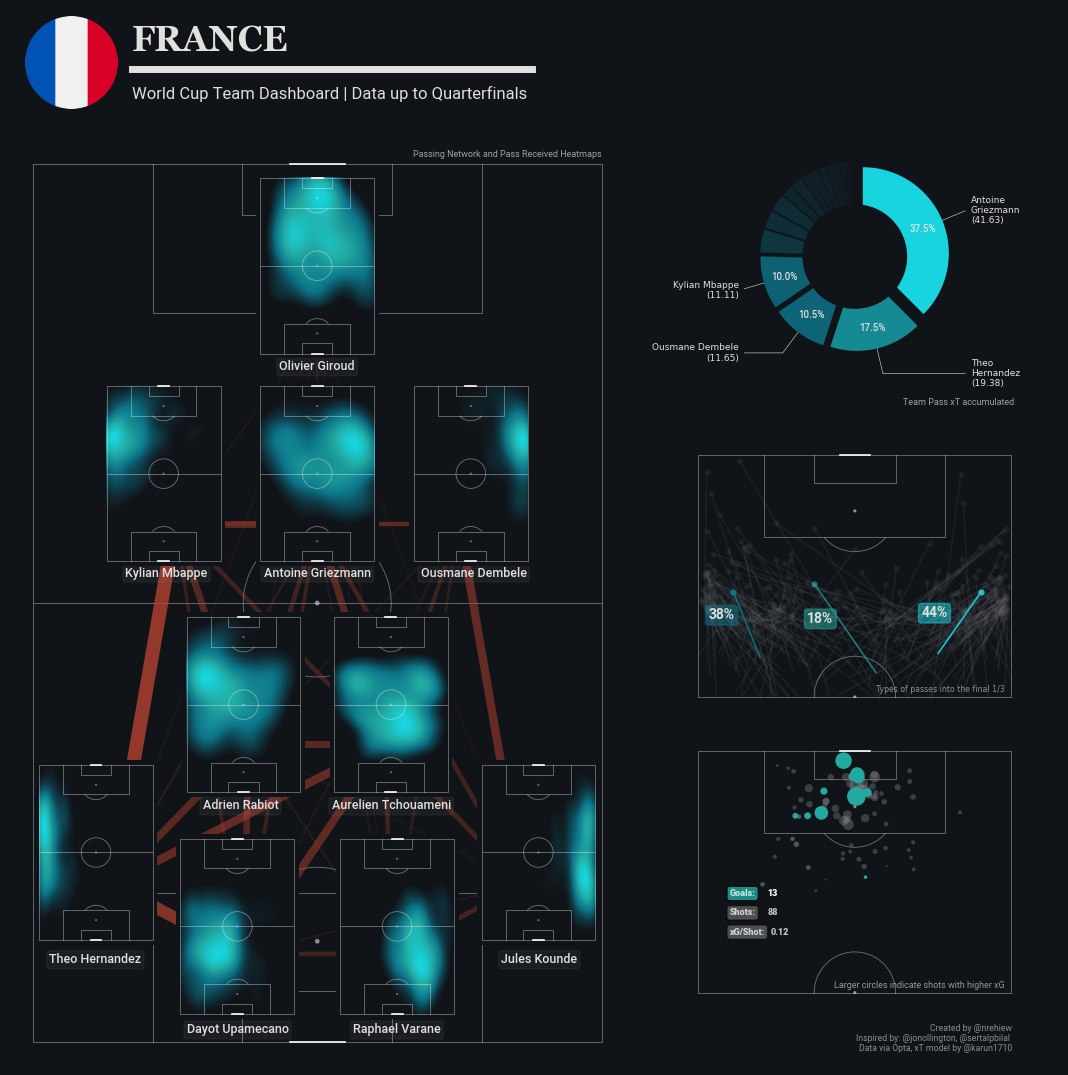

In [51]:
plt.rcParams['figure.figsize'] = [20, 12]
x_adjust = 10
y_adjust = 5
MAX_LINE_WIDTH = 10
MAX_ALPHA = 0.7
MIN_ALPHA = 0.07
XT_THRESHOLD = 5


BG_COLOR = '#101419'
cmap_lst = [BG_COLOR,'#0C7489','#22AAA1','#17D4DE']
NOTES_COLOR = '#E0E1DD'
NETWORK_COLOR ='#BB4430'
TEXTBOX = 'grey' 
CREDIT_SIZE =6
TITLE_COLOR = '#E0E1DD'
TITLE_SIZE = 28
TITLEFONT ='Georgia'
FONT = 'Roboto'
SUBTITLE_SIZE = 10



fig,ax = plt.subplots()
fig.set_facecolor(BG_COLOR)
ax = draw_network(processed,ax,player_lst)
# test_pitch = VerticalPitch(pitch_type='opta')
# test_pitch.draw(ax=ax)
cluster_ax = ax.inset_axes([1.1,0.26,0.55,0.55])
cluster_ax = cluster_passes(df,cluster_ax,cmap_lst)
shot_ax = ax.inset_axes([1.1,-0.06,0.55,0.55])
shot_ax = shotmap(df,shot_ax,cmap_lst)
xt_ax = ax.inset_axes([1.2,0.7,0.35,0.35])
xt_ax = xt_chart(df,xt_ax)

fig.text(0.86,0.138,'Created by @nrehiew',color = NOTES_COLOR,fontsize = 6.2,font = FONT,alpha=0.6,ha='right')
fig.text(0.86,0.13,'Inspired by: @jonollington, @sertalpbilal ',color = NOTES_COLOR,fontsize = 6.2,font = FONT,alpha=0.6,ha='right')
fig.text(0.86,0.122,'Data via Opta, xT model by @karun1710',color = NOTES_COLOR,fontsize = 6.2,font = FONT,alpha=0.6,ha='right')
fig.text(0.5,0.98,' ')

im_ax = ax.inset_axes([0,1.035,0.2,0.1])
a = io.imread(imageurl)
im_ax.imshow(a)
im_ax.axis('off')


fig.text(0.42,0.955,team.upper(),color = TITLE_COLOR,fontsize = 25,font = TITLEFONT,ha='left',fontweight ='bold')
_ = fig.add_artist(lines.Line2D([0.42,0.62],[0.94],linewidth=5,color=TITLE_COLOR))
fig.text(0.42,0.915,'World Cup Team Dashboard | Data up to Quarterfinals',color = NOTES_COLOR,fontsize = 12,font = FONT,ha='left')
plt.savefig(f'Completed/{team}.jpg',bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none', dpi=300)

In [ ]:
BG_COLOR = '#101419'
cmap_lst = [BG_COLOR,'#780214','#DD0426','#F02D3A']
NOTES_COLOR = '#E0E1DD'
NETWORK_COLOR ='#246B60'
TEXTBOX = 'grey' 
CREDIT_SIZE =6
TITLE_COLOR = '#E0E1DD'
TITLE_SIZE = 28
TITLEFONT ='Georgia'
FONT = 'Roboto'
SUBTITLE_SIZE = 10
sonar_lst = [NETWORK_COLOR,'#339989','#83C5BE']


fig,ax = plt.subplots()
fig.set_facecolor(BG_COLOR)
#ax = draw_network(processed,ax,player_lst)
draw_network_hex(processed,ax,player_lst)
# test_pitch = VerticalPitch(pitch_type='opta')
# test_pitch.draw(ax=ax)
cluster_ax = ax.inset_axes([1.1,0.26,0.55,0.55])
cluster_ax = plot_defence(df,cluster_ax,cmap_lst,sonar_lst)
shot_ax = ax.inset_axes([1.1,-0.06,0.55,0.55])
shot_ax = shotmap(df,shot_ax,cmap_lst)
xt_ax = ax.inset_axes([1.2,0.7,0.35,0.35])
xt_ax = xt_chart(df,xt_ax)

#fig.text(0.86,0.66,'Team Open Play Pass xT accumulated',color = NOTES_COLOR,fontsize = 6.5,alpha=0.7,font = FONT,ha='right')
fig.text(0.86,0.138,'Created by @nrehiew',color = NOTES_COLOR,fontsize = 5.5,font = FONT,alpha=0.6,ha='right')
fig.text(0.86,0.13,'Inspired by: @jonollington, @sertalpbilal ',color = NOTES_COLOR,fontsize = 5.5,font = FONT,alpha=0.6,ha='right')
fig.text(0.86,0.122,'Data via Opta, xT model by @karun1710',color = NOTES_COLOR,fontsize = 5.5,font = FONT,alpha=0.6,ha='right')
fig.text(0.5,0.98,' ')

im_ax = ax.inset_axes([0,1.035,0.2,0.1])
a = io.imread(imageurl)
im_ax.imshow(a)
im_ax.axis('off')

fig.text(0.42,0.955,team.upper(),color = TITLE_COLOR,fontsize = 25,font = TITLEFONT,ha='left',fontweight ='bold')
_ = fig.add_artist(lines.Line2D([0.42,0.62],[0.94],linewidth=5,color=TITLE_COLOR))
fig.text(0.42,0.915,'World Cup Team Dashboard | Data up to Quarterfinals',color = NOTES_COLOR,fontsize = 12,font = FONT,ha='left')
plt.savefig(f'Completed/{team}.jpg',bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none', dpi=300)